In [44]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\jaesc2\GitHub\skforecast


In [45]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from scipy.stats import norm

from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries

In [46]:
# Load time series of multiple lengths and exogenous variables
# ==============================================================================
series = pd.read_csv(
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/demo_multi_series.csv'
)
exog = pd.read_csv(
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/demo_multi_series_exog.csv'
)

series['timestamp'] = pd.to_datetime(series['timestamp'])
exog['timestamp'] = pd.to_datetime(exog['timestamp'])

display(series.head())
print("")
display(exog.head())

,series_id,timestamp,value
0,id_1000,2016-01-01,1012.500694
1,id_1000,2016-01-02,1158.500099
2,id_1000,2016-01-03,983.000099
3,id_1000,2016-01-04,1675.750496
4,id_1000,2016-01-05,1586.250694


,series_id,timestamp,sin_day_of_week,cos_day_of_week,air_temperature,wind_speed
0,id_1000,2016-01-01,-0.433884,-0.900969,6.416639,4.040115
1,id_1000,2016-01-02,-0.974928,-0.222521,6.366474,4.530395
2,id_1000,2016-01-03,-0.781831,0.623490,6.555272,3.273064
3,id_1000,2016-01-04,0.000000,1.000000,6.704778,4.865404
4,id_1000,2016-01-05,0.781831,0.623490,2.392998,5.228913


In [47]:
# Transform series and exog to dictionaries
# ==============================================================================
series_dict = series_long_to_dict(
    data      = series,
    series_id = 'series_id',
    index     = 'timestamp',
    values    = 'value',
    freq      = 'D'
)

exog_dict = exog_long_to_dict(
    data      = exog,
    series_id = 'series_id',
    index     = 'timestamp',
    freq      = 'D'
)

c:\Users\jaesc2\GitHub\skforecast\skforecast\preprocessing\preprocessing.py:425: MissingValuesWarning: Series 'id_1003' is incomplete. NaNs have been introduced after setting the frequency. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(


In [48]:
# Drop some exogenous variables for series 'id_1000' and 'id_1003'
# ==============================================================================
exog_dict['id_1000'] = exog_dict['id_1000'].drop(columns=['air_temperature', 'wind_speed'])
exog_dict['id_1003'] = exog_dict['id_1003'].drop(columns=['cos_day_of_week'])

In [49]:
# Partition data in train and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'

series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

In [50]:
# Fit forecaster
# ==============================================================================
regressor = LGBMRegressor(random_state=123, verbose=-1, max_depth=5)
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = regressor, 
                 lags               = 14, 
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[7, 14]),
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

forecaster.fit(series=series_dict_train, exog=exog_dict_train, suppress_warnings=True)
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window features: ['roll_mean_7', 'roll_mean_14'] 
Window size: 14 
Series encoding: ordinal 
Series names (levels): id_1000, id_1001, id_1002, id_1003, id_1004 
Exogenous included: True 
Exogenous names: 
    sin_day_of_week, cos_day_of_week, air_temperature, wind_speed 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: 
    'id_1000': ['2016-01-01', '2016-07-31'], 'id_1001': ['2016-07-02',
    '2016-07-31'], 'id_1002': ['2016-01-01', '2016-07-01'], 'id_1003':
    ['2016-01-01', '2016-07-31'], 'id_1004': ['2016-05-02', '2016-07-31'] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-12-29 17:07:22 
Last fit date: 2024-12-29 17:07:22 
Skforecast version: 0.15.0 
Python version: 3.11.10 
Forecaster id: None

In [51]:
preds = forecaster.predict(steps=10, exog=exog_dict_test)
preds

c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:1056: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:1056: MissingExogWarning: {'cos_day_of_week'} not present in `exog` for series 'id_1003'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:562: MissingValuesWarning: `exog` for series 'id_1000' has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py

,level,pred
2016-08-01,id_1000,1453.312971
2016-08-01,id_1001,2849.347882
2016-08-01,id_1003,2706.851726
2016-08-01,id_1004,7496.555367
2016-08-02,id_1000,1440.763196
2016-08-02,id_1001,2947.579536
2016-08-02,id_1003,2310.075968
2016-08-02,id_1004,8685.425990
2016-08-03,id_1000,1410.151437
2016-08-03,id_1001,2875.847691


In [52]:
preds = forecaster.predict_bootstrapping(
    steps=10, exog=exog_dict_test, n_boot=3, suppress_warnings=True
)
preds.head(3)

,level,pred_boot_0,pred_boot_1,pred_boot_2
2016-08-01,id_1000,1173.586189,1484.675570,1418.862097
2016-08-01,id_1001,2738.406500,3184.698632,2119.125183
2016-08-01,id_1003,2901.172020,2577.806548,2465.634521


In [53]:
preds.index

DatetimeIndex(['2016-08-01', '2016-08-01', '2016-08-01', '2016-08-01',
               '2016-08-02', '2016-08-02', '2016-08-02', '2016-08-02',
               '2016-08-03', '2016-08-03', '2016-08-03', '2016-08-03',
               '2016-08-04', '2016-08-04', '2016-08-04', '2016-08-04',
               '2016-08-05', '2016-08-05', '2016-08-05', '2016-08-05',
               '2016-08-06', '2016-08-06', '2016-08-06', '2016-08-06',
               '2016-08-07', '2016-08-07', '2016-08-07', '2016-08-07',
               '2016-08-08', '2016-08-08', '2016-08-08', '2016-08-08',
               '2016-08-09', '2016-08-09', '2016-08-09', '2016-08-09',
               '2016-08-10', '2016-08-10', '2016-08-10', '2016-08-10'],
              dtype='datetime64[ns]', freq=None)

In [54]:
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(
        n_estimators=2, random_state=123, verbose=-1, max_depth=2
    ),
    lags=14,
    encoding='ordinal',
    dropna_from_series=False,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)
forecaster.fit(
    series=series_dict_train, exog=exog_dict_train, suppress_warnings=True
)
predictions = forecaster.predict_interval(
    steps=5, exog=exog_dict_test, suppress_warnings=True, n_boot=10, interval=[5, 95]
)
predictions

,level,pred,lower_bound,upper_bound
2016-08-01,id_1000,1433.297592,1145.661830,1832.803467
2016-08-01,id_1001,2063.854011,1275.450099,2872.839822
2016-08-01,id_1003,2166.434783,1913.930958,2538.823808
2016-08-01,id_1004,7257.175987,5198.950000,8597.788342
2016-08-02,id_1000,1461.209555,761.257523,1717.132505
2016-08-02,id_1001,2088.432356,904.569576,2869.878345
2016-08-02,id_1003,2075.324745,1491.383819,2448.884434
2016-08-02,id_1004,7486.368167,5585.929861,9175.776314
2016-08-03,id_1000,1461.209555,1374.688792,1774.645023
2016-08-03,id_1001,2088.432356,905.469576,2843.495775


In [55]:
preds = forecaster.predict_interval(
    steps=3, exog=exog_dict_test, n_boot=5, suppress_warnings=True
)
preds

,level,pred,lower_bound,upper_bound
2016-08-01,id_1000,1433.297592,1098.168021,1876.018766
2016-08-01,id_1001,2063.854011,2421.537443,2872.800040
2016-08-01,id_1003,2166.434783,1783.990068,2562.371089
2016-08-01,id_1004,7257.175987,4845.647090,8452.809986
2016-08-02,id_1000,1461.209555,1264.147681,1688.978508
2016-08-02,id_1001,2088.432356,1183.824786,2836.860336
2016-08-02,id_1003,2075.324745,1702.102649,2375.071125
2016-08-02,id_1004,7486.368167,4581.928724,8873.767888
2016-08-03,id_1000,1461.209555,1153.607299,1724.122685
2016-08-03,id_1001,2088.432356,2213.523214,2760.818385


In [56]:
preds = forecaster.predict_quantiles(
    steps=3, exog=exog_dict_test, n_boot=5, suppress_warnings=True
)
preds

,level,q_0.05,q_0.5,q_0.95
2016-08-01,id_1000,1098.168021,1376.007737,1876.018766
2016-08-01,id_1001,2421.537443,2621.200199,2872.800040
2016-08-01,id_1003,1783.990068,1913.329653,2562.371089
2016-08-01,id_1004,4845.647090,8002.807820,8452.809986
2016-08-02,id_1000,1264.147681,1361.710299,1688.978508
2016-08-02,id_1001,1183.824786,2744.578544,2836.860336
2016-08-02,id_1003,1702.102649,2012.549751,2375.071125
2016-08-02,id_1004,4581.928724,7143.127712,8873.767888
2016-08-03,id_1000,1153.607299,1673.842145,1724.122685
2016-08-03,id_1001,2213.523214,2396.200100,2760.818385


In [57]:
preds = forecaster.predict_dist(
    steps=3, exog=exog_dict_test, n_boot=5, suppress_warnings=True,
    distribution=norm
)
preds

,level,loc,scale
2016-08-01,id_1000,1441.612274,303.206155
2016-08-01,id_1001,2649.004470,174.453075
2016-08-01,id_1003,2057.304558,330.286952
2016-08-01,id_1004,7209.187789,1540.635896
2016-08-02,id_1000,1446.938082,187.589553
2016-08-02,id_1001,2276.123756,717.017463
2016-08-02,id_1003,2005.781061,271.759249
2016-08-02,id_1004,6608.659478,1762.770119
2016-08-03,id_1000,1507.396277,247.561435
2016-08-03,id_1001,2471.487545,218.072526


In [58]:

preds.iloc[:, 1:].apply(
    lambda x: norm.fit(x), axis=1, result_type='expand'
)

,0,1
2016-08-01,872.409214,569.203060
2016-08-01,1411.728773,1237.275697
2016-08-01,1193.795755,863.508803
2016-08-01,4374.911843,2834.275946
2016-08-02,817.263817,629.674264
2016-08-02,1496.570610,779.553146
2016-08-02,1138.770155,867.010906
2016-08-02,4185.714798,2422.944679
2016-08-03,877.478856,629.917421
2016-08-03,1344.780035,1126.707510


In [59]:
interval = np.array([5, 95]) / 100

preds[['lower_bound', 'upper_bound']] = (
    preds.iloc[:, 1:].quantile(q=interval, axis=1).transpose()
)
preds = preds[['level', 'lower_bound', 'upper_bound']]
preds

,level,lower_bound,upper_bound
2016-08-01,id_1000,360.126461,1384.691968
2016-08-01,id_1001,298.180645,2525.276900
2016-08-01,id_1003,416.637832,1970.953678
2016-08-01,id_1004,1824.063491,6925.760194
2016-08-02,id_1000,250.556980,1383.970655
2016-08-02,id_1001,794.972778,2198.168441
2016-08-02,id_1003,358.460340,1919.079971
2016-08-02,id_1004,2005.064587,6366.365010
2016-08-03,id_1000,310.553177,1444.404535
2016-08-03,id_1001,330.743277,2358.816794


In [60]:
predictions_array = preds.to_numpy()
prediction_index = preds.index
levels = preds.columns

n_steps, n_levels = predictions_array.shape

df_long = pd.DataFrame({
    #'step':       np.repeat(prediction_index, n_levels),
    'level':      np.tile(levels, n_steps),
    'pred' : predictions_array.ravel()  # o .flatten()
},
index=np.repeat(prediction_index, n_levels))

df_long.head()

,level,pred
2016-08-01,level,id_1000
2016-08-01,lower_bound,360.126461
2016-08-01,upper_bound,1384.691968
2016-08-01,level,id_1001
2016-08-01,lower_bound,298.180645


In [119]:
# Backtesting
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 regressor          = regressor, 
                 lags               = 14, 
                 window_features    = RollingFeatures(stats=['mean', 'mean'], window_sizes=[7, 14]),
                 encoding           = "ordinal", 
                 dropna_from_series = False
             )

cv = TimeSeriesFold(
         steps                 = 24,
         initial_train_size    = len(series_dict_train["id_1000"]),
         refit                 = False,
         allow_incomplete_fold = True,
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = series_dict,
    exog                  = exog_dict,
    cv                    = cv,
    levels                = None,
    metric                = "mean_absolute_error",
    add_aggregated_metric = True,
    n_jobs                ="auto",
    verbose               = False,
    interval              = "bootstrapping",
    n_boot                = 25,
    show_progress         = True,
    suppress_warnings     = True
)

display(metrics_levels)
print("")
display(backtest_predictions)

  0%|          | 0/7 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,id_1000,167.502214
1,id_1001,1103.313887
2,id_1002,NaN
3,id_1003,280.492603
4,id_1004,711.078359
5,average,565.596766
6,weighted_average,535.467442
7,pooling,572.944127


,level,pred,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,...,pred_boot_15,pred_boot_16,pred_boot_17,pred_boot_18,pred_boot_19,pred_boot_20,pred_boot_21,pred_boot_22,pred_boot_23,pred_boot_24
2016-08-01,id_1000,1453.312971,1173.586189,1484.675570,1418.862097,1583.837825,1351.306370,1372.982760,1439.512959,1409.814539,...,1323.631696,1485.943585,1132.281444,983.341389,1398.443783,1483.429494,1474.022549,1409.243375,1470.410114,1470.410114
2016-08-01,id_1001,2849.347882,2690.225531,3315.267219,2119.125183,2462.458516,2708.835260,2462.458516,2690.225531,2577.980086,...,2708.835260,2738.406500,2738.406500,3315.267219,2888.212764,3081.756898,3081.756898,3210.573857,3133.946060,2888.212764
2016-08-01,id_1003,2706.851726,2584.527246,2539.871235,2919.298994,2643.660797,2532.615558,2790.712069,2756.217796,2869.734475,...,2598.919573,2680.117097,2688.405280,2471.135342,2782.541300,2832.232915,2843.289713,2287.494729,2770.632998,2786.290979
2016-08-01,id_1004,7496.555367,7288.915846,5797.501530,7654.538247,7309.451525,7555.799319,7211.963211,7210.689038,7569.243608,...,7746.280512,7309.451525,7203.459456,7206.599391,7607.784914,7566.729479,5797.501530,7288.915846,7218.055198,8310.772954
2016-08-02,id_1000,1440.763196,1434.802833,1500.851630,1448.720409,1479.964783,1440.970575,1402.795567,1531.175270,1404.024956,...,1450.468310,1382.930068,1443.716395,1426.529660,1474.445573,1387.315108,1161.036414,1362.734887,1457.344704,1397.264764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30,id_1001,1132.535774,486.690637,980.143039,1150.541243,1344.130896,759.371090,1096.960855,1212.352374,622.022276,...,1212.352374,1213.542041,1481.881637,1577.641217,1031.205842,1209.206300,390.432962,755.528966,1031.205842,1470.150355
2016-12-30,id_1003,2089.261345,1898.669067,2026.453904,1996.942433,2118.391255,1823.392510,1772.466935,2109.059187,1687.628235,...,2335.792632,1820.908274,2102.769041,2101.640683,2501.867497,1773.001477,1676.982167,2275.556777,1898.023625,1733.417968
2016-12-31,id_1000,1393.128313,1471.673592,1411.773924,1441.976529,1327.751241,1453.778083,1412.582346,1444.307640,1464.359752,...,1398.314933,1363.110982,1068.748507,1430.000054,1394.973479,1380.985564,1317.879488,1377.544932,1381.832287,1389.415499
2016-12-31,id_1001,1106.034061,947.305218,335.753749,1401.327198,1104.841331,1204.858857,1104.841331,1252.284776,1598.398091,...,1405.346151,785.674870,859.657225,1197.637269,1070.366800,1107.787662,1200.654903,1418.268641,670.153300,365.726196


In [120]:
predcitions = backtest_predictions[['level', 'pred']]
predcitions.head()

,level,pred
2016-08-01,id_1000,1453.312971
2016-08-01,id_1001,2849.347882
2016-08-01,id_1003,2706.851726
2016-08-01,id_1004,7496.555367
2016-08-02,id_1000,1440.763196


In [121]:
predcitions_pivot = predcitions.pivot(
    columns='level', values='pred'
).rename_axis(None, axis=1)
predcitions_pivot

,id_1000,id_1001,id_1003,id_1004
2016-08-01,1453.312971,2849.347882,2706.851726,7496.555367
2016-08-02,1440.763196,2947.579536,2310.075968,8685.425990
2016-08-03,1410.151437,2875.847691,1997.329410,8961.631705
2016-08-04,1348.787299,3160.533645,1923.897012,8764.338331
2016-08-05,1301.504387,2920.424937,1940.149954,8694.134833
...,...,...,...,...
2016-12-27,1667.998267,1108.052845,2121.157763,NaN
2016-12-28,1579.306861,1111.236661,2050.252915,NaN
2016-12-29,1487.230722,1113.581933,2063.309008,NaN
2016-12-30,1481.331642,1132.535774,2089.261345,NaN


In [109]:
predcitions_pivot = predcitions.pivot(
    columns='level', values='pred'
)

n_predictions_levels = (
            predcitions_pivot
            .notna()
            .sum()
            .to_frame(name='n_predictions')
            .reset_index(names='levels')
        )
n_predictions_levels

,levels,n_predictions
0,id_1000,153
1,id_1001,153
2,id_1003,153
3,id_1004,48


In [112]:
metrics_levels

,levels,mean_absolute_error
0,id_1000,167.502214
1,id_1001,1103.313887
2,id_1002,NaN
3,id_1003,280.492603
4,id_1004,711.078359
5,average,565.596766
6,weighted_average,535.467442
7,pooling,572.944127


In [111]:
n_predictions_levels = (
            predcitions.groupby("level")["pred"]
            .apply(lambda x: x.notna().sum())
            .reset_index(name="n_predictions")
        )
n_predictions_levels

,level,n_predictions
0,id_1000,153
1,id_1001,153
2,id_1003,153
3,id_1004,48


In [96]:
predictions = pd.DataFrame(
    data={
        "item_1": [
            25.849411, 24.507137, 23.885447, 23.597504, 23.464140, 23.402371,
            23.373762, 23.360511, 23.354374, 23.351532, 23.354278, 23.351487,
            23.350195, 23.349596, 23.349319, 23.349190, 23.349131, 23.349103,
            23.349090, 23.349084, 23.474207, 23.407034, 23.375922, 23.361512,
            23.354837
        ],
        "item_2": [
            24.561460, 23.611980, 23.172218, 22.968536, 22.874199, 22.830506,
            22.810269, 22.800896, 22.796555, 22.794544, 22.414996, 22.617821,
            22.711761, 22.755271, 22.775423, 22.784756, 22.789079, 22.791082,
            22.792009, 22.792439, 21.454419, 22.172918, 22.505700, 22.659831,
            22.731219
        ],
        "item_3": [
            26.168069, 24.057472, 23.079925, 22.627163, 22.417461, 22.320335,
            22.275350, 22.254515, 22.244865, 22.240395, 21.003848, 21.665604,
            21.972104, 22.114063, 22.179813, 22.210266, 22.224370, 22.230903,
            22.233929, 22.235330, 20.222212, 21.303581, 21.804429, 22.036402,
            22.143843
        ],
    },
    index=pd.date_range(start="2012-01-26", periods=25)
)

In [98]:
df = (
    predictions.melt(var_name="level", value_name="pred", ignore_index=False)
    .reset_index()
    .sort_values(by=["index", "level"])
    .set_index("index")
    .rename_axis(None, axis=0)
)
df

,level,pred
2012-01-26,item_1,25.849411
2012-01-26,item_2,24.561460
2012-01-26,item_3,26.168069
2012-01-27,item_1,24.507137
2012-01-27,item_2,23.611980
...,...,...
2012-02-18,item_2,22.659831
2012-02-18,item_3,22.036402
2012-02-19,item_1,23.354837
2012-02-19,item_2,22.731219


In [ ]:
pd.date_range(start="2012-01-26", periods=25)

In [107]:
df.to_dict(orient='list')

{'level': ['item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3',
  'item_1',
  'item_2',
  'item_3'],
 'pred': [25.849411,
  24.56146,
  26.168069,
  24.507137,
  23.61198,
  24.057472,
  23.8

In [8]:
import re 
import pytest
from skforecast.exceptions import IgnoredArgumentWarning
from skforecast.recursive import ForecasterRecursive
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.direct import ForecasterDirectMultiVariate
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection._split import TimeSeriesFold
from skforecast.preprocessing import RollingFeatures
from sklearn.linear_model import Ridge, LinearRegression
from skforecast.preprocessing import TimeSeriesDifferentiator

# Fixtures
from skforecast.recursive.tests.tests_forecaster_recursive_multiseries.fixtures_forecaster_recursive_multiseries import series, exog, exog_predict, expected_df_to_long_format

In [9]:
import joblib

series_dict = joblib.load(
    r"C:\Users\jaesc2\GitHub\skforecast\skforecast\model_selection\tests\fixture_sample_multi_series.joblib"
)

exog_dict = joblib.load(
    r"C:\Users\jaesc2\GitHub\skforecast\skforecast\model_selection\tests\fixture_sample_multi_series_exog.joblib"
)

In [ ]:
from skforecast.recursive.tests.tests_forecaster_recursive_multiseries.fixtures_forecaster_recursive_multiseries import series, exog, exog_predict, expected_df_to_long_format
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

transformer_exog = ColumnTransformer(
                       [('scale', StandardScaler(), ['exog_1']),
                        ('onehot', OneHotEncoder(), ['exog_2'])],
                       remainder = 'passthrough',
                       verbose_feature_names_out = False
                   )

In [26]:
forecaster = ForecasterRecursiveMultiSeries(
                    regressor          = LinearRegression(),
                    lags               = 3,
                    transformer_series = StandardScaler(),
                    transformer_exog   = transformer_exog,
                )

forecaster.fit(series=series, exog=exog)
forecaster.out_sample_residuals_ = forecaster.in_sample_residuals_
results = forecaster.predict_dist(
                steps                   = 2,
                distribution            = norm,
                levels                  = None,
                exog                    = exog_predict,
                n_boot                  = 4,
                use_in_sample_residuals = False
            )

In [27]:
results.index

Index([50, 50, 51, 51], dtype='int64')

In [28]:
results.to_dict(orient='list')

{'level': ['1', '2', '1', '2'],
 'loc': [0.3071804611998517,
  0.5812127014174517,
  0.33695529446570166,
  0.1296887412374588],
 'scale': [0.1435578185939024,
  0.317378881479421,
  0.21900963160500286,
  0.06418038020863531]}

In [30]:
end_train = "2016-07-31 23:59:00"
series_dict_train = {k: v.loc[:end_train,] for k, v in series_dict.items()}
exog_dict_train = {k: v.loc[:end_train,] for k, v in exog_dict.items()}
series_dict_test = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

In [32]:
rolling = RollingFeatures(stats=['mean', 'median'], window_sizes=[5, 5])
rolling_2 = RollingFeatures(stats='sum', window_sizes=[6])

forecaster = ForecasterRecursiveMultiSeries(
    regressor          = LGBMRegressor(
        n_estimators=15, random_state=123, verbose=-1, max_depth=5
    ),
    lags               = [1, 5],
    window_features    = [rolling, rolling_2],
    encoding           = 'ordinal',
    dropna_from_series = False,
    transformer_series = StandardScaler(),
    transformer_exog   = StandardScaler(),
    differentiation    = 1
)
forecaster.fit(
    series=series_dict_train, exog=exog_dict_train, suppress_warnings=True
)
steps = 5
levels = ['id_1000', 'id_1001', 'id_1003', 'id_1004', 'id_1005']
last_window = pd.DataFrame(
    {k: v for k, v in forecaster.last_window_.items() if k in levels}
)
last_window['id_1005'] = last_window['id_1004']
X_predict = forecaster.create_predict_X(
            steps=steps, levels=levels, last_window=last_window, exog=exog_dict_test
        )
X_predict

c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:885: UnknownLevelWarning: `levels` {'id_1005'} were not included in training. Unknown levels are encoded as NaN, which may cause the prediction to fail if the regressor does not accept NaN values. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=UnknownLevelWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:1006: MissingExogWarning: `exog` does not contain keys for levels {'id_1005'}. Missing levels are filled with NaN. Most of machine learning models do not allow missing values. Prediction method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingExogWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\utils\utils.py:1056: MissingExogWarning: {'wind_speed', 'air_temperature'} not present in `exog` for series 'id_1000'. All values will be NaN. 
 You can suppress this warning using: warnings.simplefi

{'id_1000':                lag_1     lag_5  roll_mean_5  roll_median_5  roll_sum_6  \
 2016-08-01 -0.697698 -0.193974    -0.323438      -0.193974   -0.614246   
 2016-08-02  1.171041 -0.104505    -0.050435      -0.104505   -0.446147   
 2016-08-03  0.103374 -0.039094    -0.008859      -0.039094   -0.148799   
 2016-08-04 -0.073478 -0.581918    -0.015736      -0.073478   -0.117772   
 2016-08-05 -0.044274 -0.697698     0.091793      -0.044274   -0.122953   
 
             _level_skforecast  sin_day_of_week  cos_day_of_week  \
 2016-08-01                0.0         0.013360         1.418563   
 2016-08-02                0.0         1.117944         0.885549   
 2016-08-03                0.0         1.390753        -0.312121   
 2016-08-04                0.0         0.626357        -1.272578   
 2016-08-05                0.0        -0.599638        -1.272578   
 
             air_temperature  wind_speed  
 2016-08-01              NaN         NaN  
 2016-08-02              NaN         NaN 

In [35]:
expected = forecaster.predict(
        steps=steps, levels=levels, last_window=last_window, exog=exog_dict_test
    ,suppress_warnings=True)
expected

,level,pred
2016-08-01,id_1000,1260.897290
2016-08-01,id_1001,2875.151550
2016-08-01,id_1003,3366.124091
2016-08-01,id_1004,6554.974184
2016-08-01,id_1005,6460.940739
2016-08-02,id_1000,1295.271547
2016-08-02,id_1001,2876.070755
2016-08-02,id_1003,3044.452566
2016-08-02,id_1004,6917.368376
2016-08-02,id_1005,7934.026906


In [ ]:
expected.pivot(columns='level', values='pred').rename_axis(None, axis=1)

,id_1000,id_1001,id_1003,id_1004,id_1005
2016-08-01,1260.897290,2875.151550,3366.124091,6554.974184,6460.940739
2016-08-02,1295.271547,2876.070755,3044.452566,6917.368376,7934.026906
2016-08-03,1270.838522,2858.314337,2722.781041,7221.973905,8287.723282
2016-08-04,1256.116455,2796.857862,2498.495617,8214.091986,8545.006588
2016-08-05,1241.394388,2706.908116,2369.702865,8582.612349,8453.817369


In [42]:
refit = 0

refit is False

False

In [16]:
expected = pd.DataFrame(
                   data    = np.array([[0.12837500, 0.33920342, 0.47157640],
                                       [0.09385929, 0.32079042, 0.62315962]]),
                   columns = ['1_q_0.05', '1_q_0.55', '1_q_0.95'],
                   index   = pd.RangeIndex(start=50, stop=52)
               )
expected

,1_q_0.05,1_q_0.55,1_q_0.95
50,0.128375,0.339203,0.471576
51,0.093859,0.320790,0.623160


In [122]:
import re
import pytest
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.direct import ForecasterDirectMultiVariate
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection._utils import _predict_and_calculate_metrics_one_step_ahead_multiseries
from skforecast.model_selection._split import TimeSeriesFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from skforecast.metrics import mean_absolute_scaled_error

In [125]:
series = pd.read_parquet(r"C:\Users\jaesc2\GitHub\skforecast\skforecast\model_selection\tests\fixture_multi_series_items_sales.parquet")
series = series.asfreq('D')
exog = pd.DataFrame({'day_of_week': series.index.dayofweek}, index = series.index)


In [126]:
forecaster = ForecasterRecursiveMultiSeries(
            regressor=Ridge(random_state=678), lags=3, forecaster_id='multiseries_no_transformer'
        )

c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py:424: UserWarning: When using a linear model, it is recommended to use a transformer_series to ensure all series are in the same scale. You can use, for example, a `StandardScaler` from sklearn.preprocessing.
  warnings.warn(


In [136]:
initial_train_size = 927
metrics = ['mean_absolute_error', mean_absolute_percentage_error, mean_absolute_scaled_error]

if type(forecaster) is ForecasterRecursiveMultiSeries:
    levels = ['item_1', 'item_2', 'item_3']
else:
    levels = ['item_1']

cv = TimeSeriesFold(
            initial_train_size = initial_train_size,
            steps              = 1,
            refit              = False,
            differentiation    = forecaster.differentiation_max
        )

metrics_backtesting, pred_backtesting = backtesting_forecaster_multiseries(
    series=series,
    exog=exog,
    forecaster=forecaster,
    cv=cv,
    metric=metrics,
    levels=levels,
    add_aggregated_metric=True,
    show_progress=False
)
pred_backtesting = (
    pred_backtesting
    .pivot(columns='level', values='pred')
    .rename_axis(None, axis=0)
    .rename_axis(None, axis=1)
)

(
    X_train,
    y_train,
    X_test,
    y_test,
    X_train_encoding,
    X_test_encoding
) = forecaster._train_test_split_one_step_ahead(
        series             = series,
        exog               = exog,
        initial_train_size = initial_train_size,
    )

metrics_one_step_ahead, pred_one_step_ahead = _predict_and_calculate_metrics_one_step_ahead_multiseries(
    forecaster=forecaster,
    series=series,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    X_train_encoding = X_train_encoding,
    X_test_encoding = X_test_encoding,
    levels = levels,
    metrics = metrics,
    add_aggregated_metric = True
)

In [138]:
forecaster = ForecasterRecursiveMultiSeries(
            regressor          = LGBMRegressor(random_state=123, verbose=-1),
            lags               = 24,
            encoding           = 'ordinal',
            transformer_series = StandardScaler(),
            transformer_exog   = StandardScaler(),
            weight_func        = None,
            series_weights     = None,
            differentiation    = None,
            dropna_from_series = False,
            forecaster_id      = 'multiseries_lgbm'
        )

In [156]:
initial_train_size = 213
metrics = ['mean_absolute_error', mean_absolute_percentage_error, mean_absolute_scaled_error]
levels = ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']

cv = TimeSeriesFold(
        initial_train_size = initial_train_size,
        steps              = 1,
        refit              = False,
    )

metrics_backtesting, pred_backtesting_raw = backtesting_forecaster_multiseries(
    series=series_dict,
    exog=exog_dict,
    forecaster=forecaster,
    cv=cv,
    metric=metrics,
    levels=levels,
    add_aggregated_metric=True,
    show_progress=False,
    suppress_warnings=True
)
pred_backtesting = (
    pred_backtesting_raw
    .pivot(columns='level', values='pred')
    .rename_axis(None, axis=0)
    .rename_axis(None, axis=1)
    .asfreq('D')
)

(
    X_train,
    y_train,
    X_test,
    y_test,
    X_train_encoding,
    X_test_encoding
) = forecaster._train_test_split_one_step_ahead(
        series             = series_dict,
        exog               = exog_dict,
        initial_train_size = initial_train_size,
    )

metrics_one_step_ahead, pred_one_step_ahead = _predict_and_calculate_metrics_one_step_ahead_multiseries(
    forecaster=forecaster,
    series=series_dict,
    X_train = X_train,
    y_train= y_train,
    X_test = X_test,
    y_test = y_test,
    X_train_encoding = X_train_encoding,
    X_test_encoding = X_test_encoding,
    levels = levels,
    metrics = metrics,
    add_aggregated_metric = True
)

c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py:1134: MissingValuesWarning: NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py:1156: MissingValuesWarning: NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
c:\Users\jaesc2\GitHub\skforecast\skforecast\recursive\_forecaster_recursive_multiseries.py:1134: MissingValuesWarning: NaNs detected in `y_train`. T

,levels,n_predictions
0,id_1000,153
1,id_1001,153
2,id_1003,80
3,id_1004,31


C:\Users\jaesc2\AppData\Local\Temp\ipykernel_25092\940690438.py:16: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


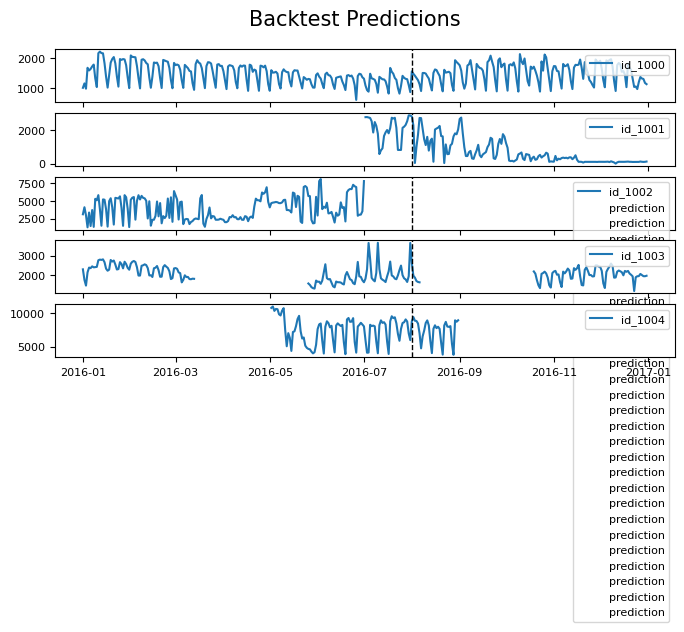

In [167]:
# Plot backtesting predictions
# ==============================================================================
fig, axs = plt.subplots(5, 1, figsize=(8, 4), sharex=True)

for i, s in enumerate(series_dict.keys()):
    axs[i].plot(series_dict[s], label=series_dict[s].name)
    axs[i].axvline(pd.to_datetime(end_train), color='black', linestyle='--', linewidth=1)  # End train
    try:
        axs[i].plot(backtest_predictions.query("level == @s"), label='prediction', color="white")
    except:
        pass
    axs[i].legend(loc='upper right', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

fig.suptitle('Backtest Predictions', fontsize=15)
plt.tight_layout()

In [140]:
metrics_one_step_ahead

,levels,mean_absolute_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,id_1000,131.744989,9.067627e-02,0.629050
1,id_1001,895.130291,3.377301e+16,5.896774
2,id_1002,NaN,NaN,NaN
3,id_1003,204.437602,1.032560e-01,0.819291
4,id_1004,784.022796,1.156924e-01,0.618558
5,average,503.833919,8.443253e+15,1.990918
6,weighted_average,474.272500,1.239154e+16,2.597529
7,pooling,474.272500,1.239154e+16,1.162049


In [141]:
metrics_backtesting

,levels,mean_absolute_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,id_1000,131.744989,9.067627e-02,0.629050
1,id_1001,895.130291,3.377301e+16,5.896774
2,id_1002,NaN,NaN,NaN
3,id_1003,204.437602,1.032560e-01,0.819291
4,id_1004,784.022796,1.156924e-01,0.618558
5,average,503.833919,8.443253e+15,1.990918
6,weighted_average,434.785337,1.052397e+16,2.329117
7,pooling,474.272500,1.239154e+16,1.162049


In [143]:
n_predictions_levels = (
    pred_backtesting_raw.groupby("level")["pred"]
    .apply(lambda x: x.notna().sum())
    .reset_index(name="n_predictions")
    .rename(columns={"level": "levels"})
)
n_predictions_levels

,levels,n_predictions
0,id_1000,153
1,id_1001,153
2,id_1003,153
3,id_1004,32


In [168]:
series_dict['id_1003'].loc[:end_train].isna().sum()

73

In [171]:
pred_backtesting_raw.query("level == 'id_1003'")

,level,pred
2016-08-01,id_1003,2744.685178
2016-08-02,id_1003,2148.282157
2016-08-03,id_1003,1857.023596
2016-08-04,id_1003,1869.321693
2016-08-05,id_1003,1725.126349
...,...,...
2016-12-27,id_1003,1970.668980
2016-12-28,id_1003,2011.922765
2016-12-29,id_1003,2092.502585
2016-12-30,id_1003,1874.931127


In [144]:
n_predictions_levels = (
    pred_backtesting
    .notna()
    .sum()
    .to_frame(name='n_predictions')
    .reset_index(names='levels')
)
n_predictions_levels

,levels,n_predictions
0,id_1000,153
1,id_1001,153
2,id_1003,153
3,id_1004,32


In [146]:
metrics_backtesting

,levels,mean_absolute_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,id_1000,131.744989,9.067627e-02,0.629050
1,id_1001,895.130291,3.377301e+16,5.896774
2,id_1002,NaN,NaN,NaN
3,id_1003,204.437602,1.032560e-01,0.819291
4,id_1004,784.022796,1.156924e-01,0.618558
5,average,503.833919,8.443253e+15,1.990918
6,weighted_average,434.785337,1.052397e+16,2.329117
7,pooling,474.272500,1.239154e+16,1.162049


In [149]:
metrics_levels = metrics_backtesting[['levels', 'mean_absolute_error']]
metrics_levels = metrics_levels[metrics_levels['levels'] != 'average']
metrics_levels = metrics_levels[metrics_levels['levels'] != 'weighted_average']
metrics_levels = metrics_levels[metrics_levels['levels'] != 'pooling']

metrics_levels_no_missing = (
    metrics_levels.merge(n_predictions_levels, on='levels', how='inner')
)
metrics_levels_no_missing

,levels,mean_absolute_error,n_predictions
0,id_1000,131.744989,153
1,id_1001,895.130291,153
2,id_1003,204.437602,153
3,id_1004,784.022796,32


In [151]:
weighted_averages = {}
for col in ['mean_absolute_error']:
    weighted_averages[col] = np.average(
        metrics_levels_no_missing[col],
        weights=metrics_levels_no_missing['n_predictions']
    )
weighted_average = pd.DataFrame(weighted_averages, index=[0])
weighted_average['levels'] = 'weighted_average'
weighted_average

,mean_absolute_error,levels
0,434.785337,weighted_average


In [157]:
pred_one_step_ahead
n_predictions_levels = (
    pred_one_step_ahead
    .notna()
    .sum()
    .to_frame(name='n_predictions')
    .reset_index(names='levels')
)
n_predictions_levels

,levels,n_predictions
0,id_1000,153
1,id_1001,153
2,id_1003,80
3,id_1004,31


In [154]:
metrics_one_step_ahead

,levels,mean_absolute_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,id_1000,131.744989,9.067627e-02,0.629050
1,id_1001,895.130291,3.377301e+16,5.896774
2,id_1002,NaN,NaN,NaN
3,id_1003,204.437602,1.032560e-01,0.819291
4,id_1004,784.022796,1.156924e-01,0.618558
5,average,503.833919,8.443253e+15,1.990918
6,weighted_average,474.272500,1.239154e+16,2.597529
7,pooling,474.272500,1.239154e+16,1.162049


In [155]:
n_predictions_levels = {
    k: v['y_pred'].notna().sum()
    for k, v in predictions_per_level.items()
}

NameError: name 'predictions_per_level' is not defined

In [345]:
initial_train_size = 213
metrics = ['mean_absolute_error', mean_absolute_percentage_error, mean_absolute_scaled_error]
levels = ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']

cv = TimeSeriesFold(
        initial_train_size = initial_train_size,
        steps              = 1,
        refit              = False,
    )

metrics_backtesting, pred_backtesting_raw = backtesting_forecaster_multiseries(
    series=series_dict,
    exog=exog_dict,
    forecaster=forecaster,
    cv=cv,
    metric=metrics,
    levels=levels,
    add_aggregated_metric=True,
    show_progress=False,
    suppress_warnings=True,
    n_jobs=1
)

In [346]:
pred_backtesting_raw.query("level == 'id_1003'").shape

(153, 2)

In [347]:
series_dict['id_1003'].loc[end_train:].isna().sum()

73

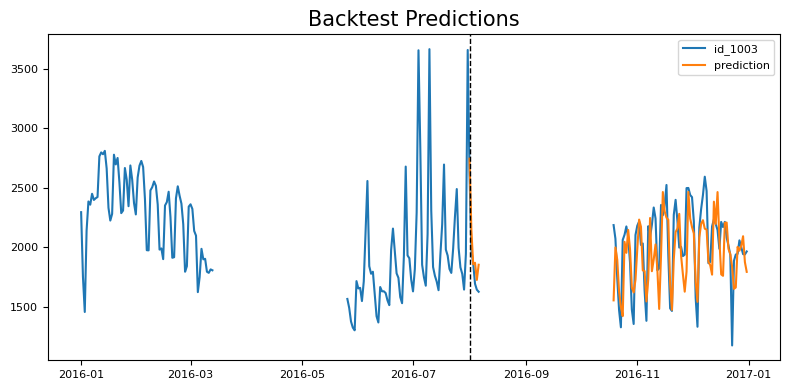

In [348]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(series_dict['id_1003'], label='id_1003')
ax.plot(pred_backtesting_raw.query("level == 'id_1003'")['pred'], label='prediction')
ax.axvline(pd.to_datetime(end_train), color='black', linestyle='--', linewidth=1)  # End train
ax.legend(loc='upper right', fontsize=8)
ax.tick_params(axis='both', labelsize=8)
plt.title('Backtest Predictions', fontsize=15)
plt.tight_layout()


In [337]:
backtest_predictions

,level,pred,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,...,pred_boot_15,pred_boot_16,pred_boot_17,pred_boot_18,pred_boot_19,pred_boot_20,pred_boot_21,pred_boot_22,pred_boot_23,pred_boot_24
2016-08-01,id_1000,1453.312971,1173.586189,1484.675570,1418.862097,1583.837825,1351.306370,1372.982760,1439.512959,1409.814539,...,1323.631696,1485.943585,1132.281444,983.341389,1398.443783,1483.429494,1474.022549,1409.243375,1470.410114,1470.410114
2016-08-01,id_1001,2849.347882,2690.225531,3315.267219,2119.125183,2462.458516,2708.835260,2462.458516,2690.225531,2577.980086,...,2708.835260,2738.406500,2738.406500,3315.267219,2888.212764,3081.756898,3081.756898,3210.573857,3133.946060,2888.212764
2016-08-01,id_1003,2706.851726,2584.527246,2539.871235,2919.298994,2643.660797,2532.615558,2790.712069,2756.217796,2869.734475,...,2598.919573,2680.117097,2688.405280,2471.135342,2782.541300,2832.232915,2843.289713,2287.494729,2770.632998,2786.290979
2016-08-01,id_1004,7496.555367,7288.915846,5797.501530,7654.538247,7309.451525,7555.799319,7211.963211,7210.689038,7569.243608,...,7746.280512,7309.451525,7203.459456,7206.599391,7607.784914,7566.729479,5797.501530,7288.915846,7218.055198,8310.772954
2016-08-02,id_1000,1440.763196,1434.802833,1500.851630,1448.720409,1479.964783,1440.970575,1402.795567,1531.175270,1404.024956,...,1450.468310,1382.930068,1443.716395,1426.529660,1474.445573,1387.315108,1161.036414,1362.734887,1457.344704,1397.264764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30,id_1001,1132.535774,486.690637,980.143039,1150.541243,1344.130896,759.371090,1096.960855,1212.352374,622.022276,...,1212.352374,1213.542041,1481.881637,1577.641217,1031.205842,1209.206300,390.432962,755.528966,1031.205842,1470.150355
2016-12-30,id_1003,2089.261345,1898.669067,2026.453904,1996.942433,2118.391255,1823.392510,1772.466935,2109.059187,1687.628235,...,2335.792632,1820.908274,2102.769041,2101.640683,2501.867497,1773.001477,1676.982167,2275.556777,1898.023625,1733.417968
2016-12-31,id_1000,1393.128313,1471.673592,1411.773924,1441.976529,1327.751241,1453.778083,1412.582346,1444.307640,1464.359752,...,1398.314933,1363.110982,1068.748507,1430.000054,1394.973479,1380.985564,1317.879488,1377.544932,1381.832287,1389.415499
2016-12-31,id_1001,1106.034061,947.305218,335.753749,1401.327198,1104.841331,1204.858857,1104.841331,1252.284776,1598.398091,...,1405.346151,785.674870,859.657225,1197.637269,1070.366800,1107.787662,1200.654903,1418.268641,670.153300,365.726196


In [339]:
backtest_predictions = (
        backtest_predictions[['level', 'pred']]
        .rename_axis('idx', axis=0)
        .set_index('level', append=True)
    )
backtest_predictions

KeyError: "['level'] not in index"

In [340]:

backtest_predictions

pred
idx        level               
2016-08-01 id_1000  1453.312971
           id_1001  2849.347882
           id_1003  2706.851726
           id_1004  7496.555367
2016-08-02 id_1000  1440.763196
...                         ...
2016-12-30 id_1001  1132.535774
           id_1003  2089.261345
2016-12-31 id_1000  1393.128313
           id_1001  1106.034061
           id_1003  2064.475030

[507 rows x 1 columns]

In [342]:
backtest_predictions.reset_index('level').rename_axis(None, axis=0)

,level,pred
2016-08-01,id_1000,1453.312971
2016-08-01,id_1001,2849.347882
2016-08-01,id_1003,2706.851726
2016-08-01,id_1004,7496.555367
2016-08-02,id_1000,1440.763196
...,...,...
2016-12-30,id_1001,1132.535774
2016-12-30,id_1003,2089.261345
2016-12-31,id_1000,1393.128313
2016-12-31,id_1001,1106.034061
